# Классификация документов
# Часть 2. Нейросетевые модели
Выборка разбивается на обучающую и тестовую в соотношении 70/30.

# Оглавление
* Средний вектор документа  
* Взвешенный средний вектор  
* Paragraph vector  

Для параллельного вычисления

In [1]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


Необходимые библиотеки

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import pandas as pd
import numpy as np
import scipy.sparse as sparse

import gensim
import fasttext
from gensim.models import word2vec
from gensim.models.phrases import Phrases, Phraser

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
pd.set_option('display.mpl_style', 'default')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 1.5})

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
%matplotlib inline

seed_test = 31415
seed_valid = 27182

Сериализация python-объектов

In [3]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

# Word2vec
## Средний вектор документа

In [4]:
path_to_data = '/home/kulesh271828/arxiv/models/word2vec/'

In [4]:
files = [file for file in os.listdir(path_to_data) if 'average' in file]
files

['average_ft-idf_ft_cbow_300.model.pkl',
 'average_w2v_cbow_500.bin.pkl',
 'average-idf_w2v_cbow_500.pkl',
 'average-tfidf_cbow_500.bin.pkl',
 'average-tfidf_sg_500.bin.pkl',
 'average-idf_w2v_sg_500.pkl',
 'average_ft-idf_ft_sg_300.model.pkl',
 'average_w2v_sg_200.bin.pkl',
 'average_w2v_cbow_200.bin.pkl',
 'average-tfidf_w2v_sg_500.pkl',
 'average-tfidf_w2v_cbow_500.pkl',
 'average_w2v_sg_500.bin.pkl',
 'average_w2v_cbow_200_trigram.bin.pkl',
 'average_w2v_cbow_100.bin.pkl',
 'average_w2v_sg_100.bin.pkl',
 'average_w2v_sg_200_trigram.bin.pkl']

In [5]:
def modeling(clf, parameters, X, y, name, normalizing=True, k=5, n_jobs=8, verbose=2):
    '''
    Desciption
    '''
    if normalizing:
        X = normalize(X, norm='l2', axis=1)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_test, test_size=0.3)
    
    skf = StratifiedKFold(n_splits=k, random_state=seed_valid)
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    gs = GridSearchCV(clf, parameters, cv=skf, verbose=verbose, n_jobs=n_jobs, scoring=f1_scorer)
    print("Searching best parameters...")
    gs.fit(X_train, y_train)
    pickling_data(name, gs)
    print("Best parameters: %s" % gs.best_params_)
    
    ind = gs.best_index_
    mean_train = gs.cv_results_['mean_train_score'][ind]
    std_train = gs.cv_results_['std_train_score'][ind]
    mean_valid = gs.cv_results_['mean_test_score'][ind]
    std_valid = gs.cv_results_['std_test_score'][ind]
    
    print("Training best model on full train data...")
    clf = gs.best_estimator_
    %time clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_test = f1_score(y_pred, y_test, average='weighted')
    
    print("Train score: %.3f +/- %.3f" % (mean_train, std_train))
    print("CV score: %.3f +/- %.3f" % (mean_valid, std_valid))
    print("Test score: %.3f\n" % score_test)

Целевая переменная

In [6]:
y = np.array(pd.read_csv('category_title.csv', usecols=['primary_category']).fillna('math.PR')).flatten()

### Логистическая регрессия

In [14]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(6,11)]}

#names = ['average_w2v_cbow_100.bin.pkl', 'average_w2v_sg_100.bin.pkl',
#         'average_w2v_cbow_200.bin.pkl', 'average_w2v_sg_200.bin.pkl',
#         'average_w2v_cbow_200_trigram.bin.pkl', 'average_w2v_sg_200_trigram.bin.pkl',
#         'average_w2v_cbow_500.bin.pkl', 'average_w2v_sg_500.bin.pkl']

names = ['average_w2v_cbow_500.bin.pkl', 'average_w2v_sg_500.bin.pkl']

for name in names:
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-8], k=3, verbose=1, n_jobs=1, normalizing=False)
    print('\n')

Number of features: 500
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 22.8min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 20min 34s, sys: 44 ms, total: 20min 34s
Wall time: 2min 57s
Train score: 0.812 +/- 0.000
CV score: 0.784 +/- 0.001
Test score: 0.794

CPU times: user 3h 18min 9s, sys: 4.21 s, total: 3h 18min 13s
Wall time: 28min 41s


Number of features: 500
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 27.7min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 14min 9s, sys: 40 ms, total: 14min 9s
Wall time: 1min 59s
Train score: 0.825 +/- 0.001
CV score: 0.801 +/- 0.001
Test score: 0.807

CPU times: user 3h 40min 21s, sys: 4.59 s, total: 3h 40min 26s
Wall time: 31min 44s




#### Коэффициенты регрессии

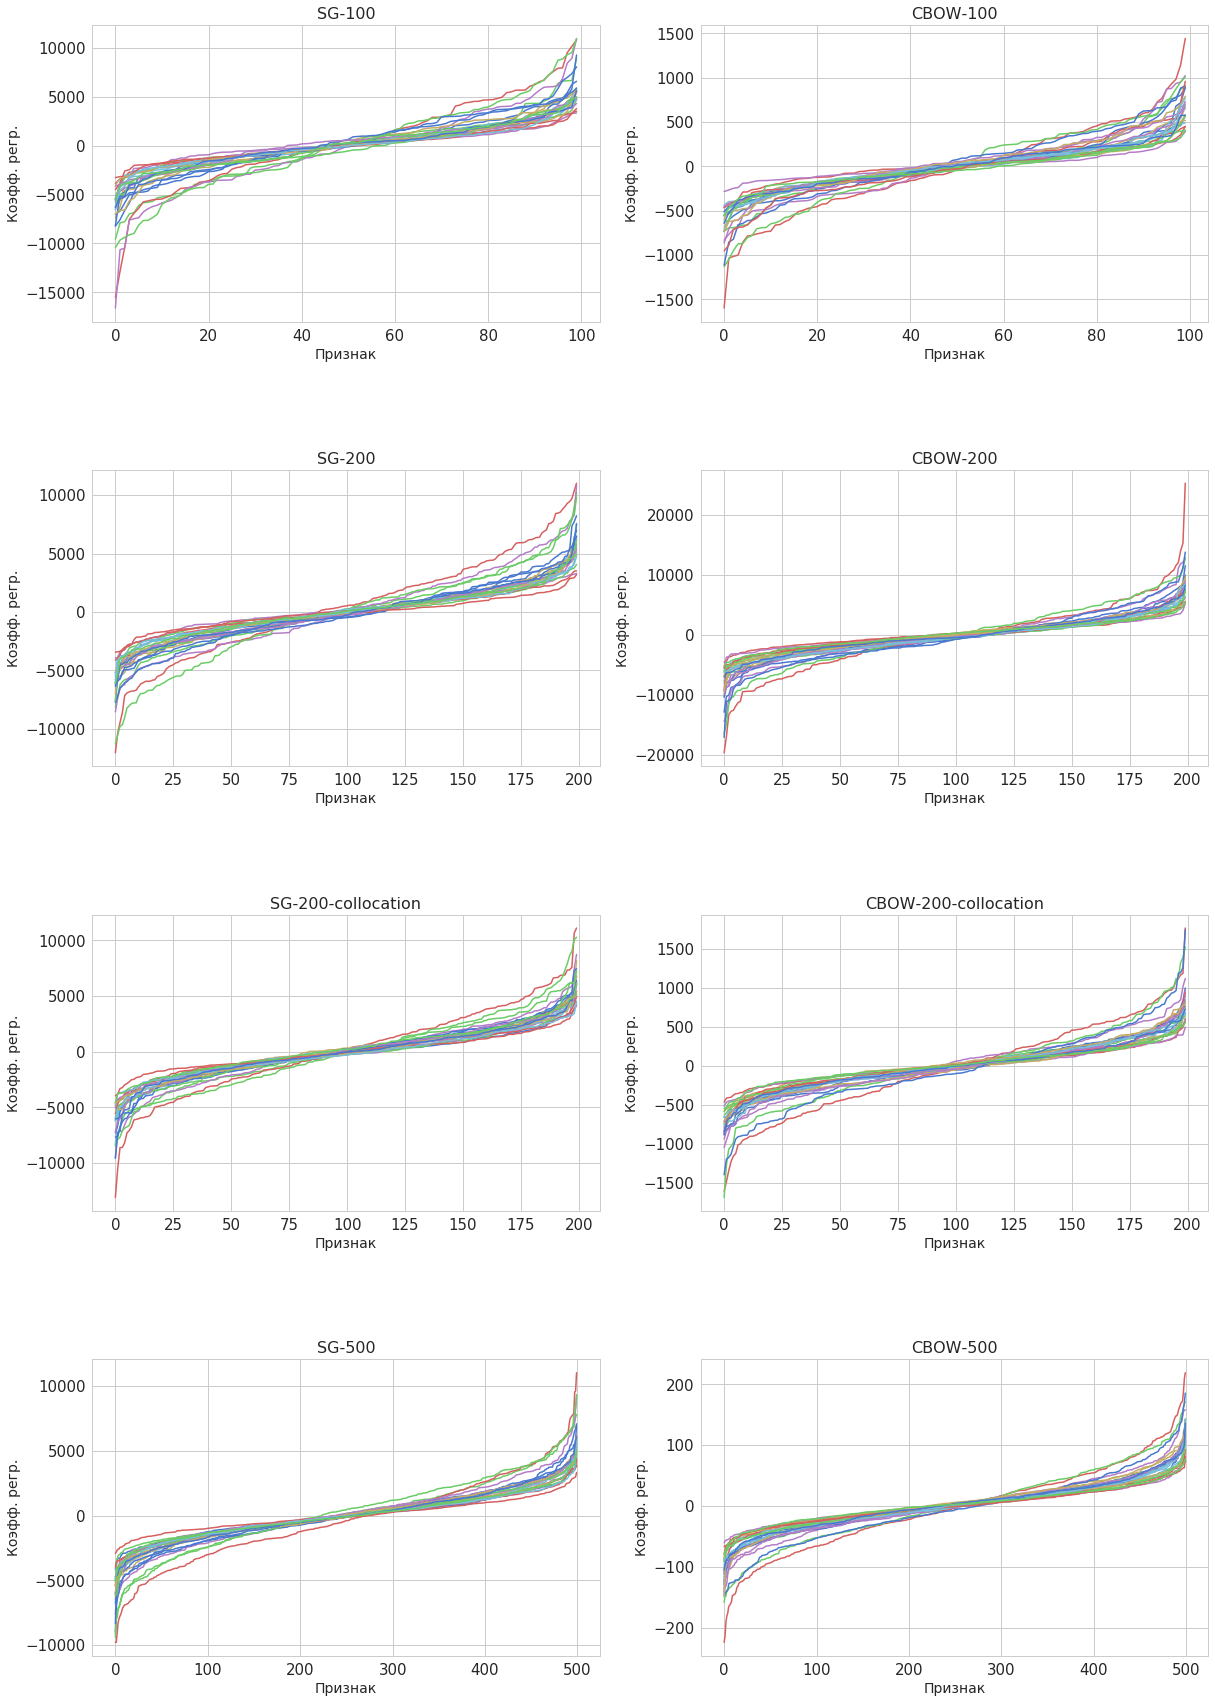

In [7]:
grids = ['gs_sgd-logistic-average_w2v_sg_100.pkl','gs_sgd-logistic-average_w2v_cbow_100.pkl', \
         'gs_sgd-logistic-average_w2v_sg_200.pkl','gs_sgd-logistic-average_w2v_cbow_200.pkl', \
         'gs_sgd-logistic-average_w2v_sg_200_trigram.pkl', 'gs_sgd-logistic-average_w2v_cbow_200_trigram.pkl', \
         'gs_sgd-logistic-average_w2v_sg_500.pkl', 'gs_sgd-logistic-average_w2v_cbow_500.pkl'
        ]
labels = ['SG-100','CBOW-100','SG-200','CBOW-200','SG-200-collocation','CBOW-200-collocation','SG-500','CBOW-500']

def plot_coefs(grids, labels, n_row=4):
    '''
    Plotting model coefficients
    '''
    plt.figure(figsize=(20,30))
    for i, grid in enumerate(grids):
        gs = load_data(grid)
        plt.subplot(n_row,2,i+1)
        for j in range(26):
            plt.plot(sorted(gs.best_estimator_.coef_[j]))
        plt.xlabel('Признак', fontsize=14)
        plt.ylabel('Коэфф. регр.', fontsize=14)
        plt.title(labels[i], fontsize=16)
    plt.legend()
    plt.show()
    
plot_coefs(grids, labels)

**Результаты кросс-валидации**

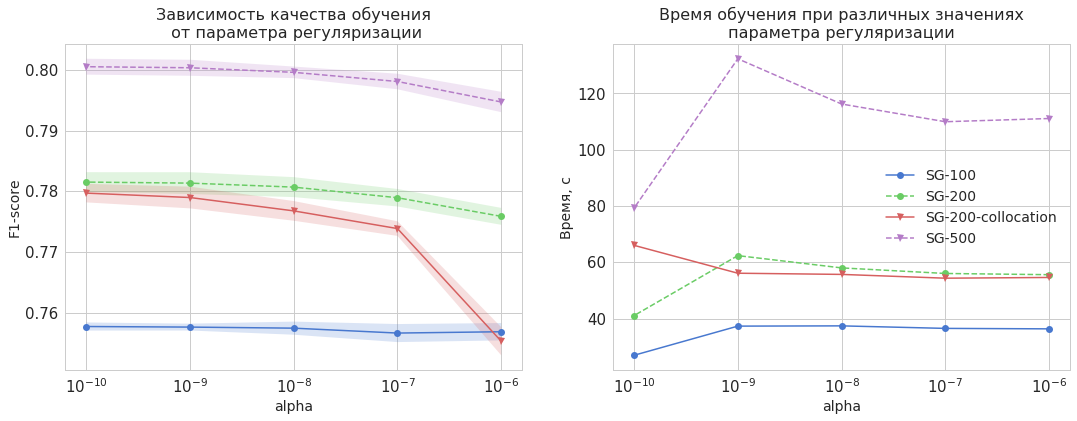

In [8]:
marks = ['o-','o--','v-','v--']
grids = ['gs_sgd-logistic-average_w2v_sg_100.pkl', \
         'gs_sgd-logistic-average_w2v_sg_200.pkl', \
         'gs_sgd-logistic-average_w2v_sg_200_trigram.pkl', \
         'gs_sgd-logistic-average_w2v_sg_500.pkl']
labels = ['SG-100','SG-200','SG-200-collocation','SG-500']
text = ["Зависимость качества обучения\n от параметра регуляризации",\
        "Время обучения при различных значениях\nпараметра регуляризации"]

def plot_cv(grids, labels, marks, title=text, log_scale=True): 
    '''
    Plotting model quality value with different regularization parameters
    '''
    plt.figure(figsize=(18,6))
    
    for i, grid in enumerate(grids):
        gs = load_data(grid)
        params = gs.cv_results_['params']
        p_name = list(params[0])[0]
        vals = [p[p_name] for p in params]
        scores = gs.cv_results_['mean_test_score']
        stds = gs.cv_results_['std_test_score']
        timing = gs.cv_results_['mean_fit_time']
        
        plt.subplot(1,2,1)
        plt.plot(vals, scores, marks[i], label=labels[i])
        plt.fill_between(vals, scores - stds, scores + stds, alpha=0.2, lw=0.1)
        plt.title(text[0], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('F1-score', fontsize=14)
        if log_scale:
            plt.xscale('log')
        
        plt.subplot(1,2,2)
        plt.plot(vals, timing, marks[i], label=labels[i])
        plt.title(text[1], fontsize=16)
        plt.xlabel(p_name, fontsize=14)
        plt.ylabel('Время, с', fontsize=14)
        if log_scale:
            plt.xscale('log')
        plt.legend(fontsize=14)

    plt.show()
    
plot_cv(grids, labels, marks)

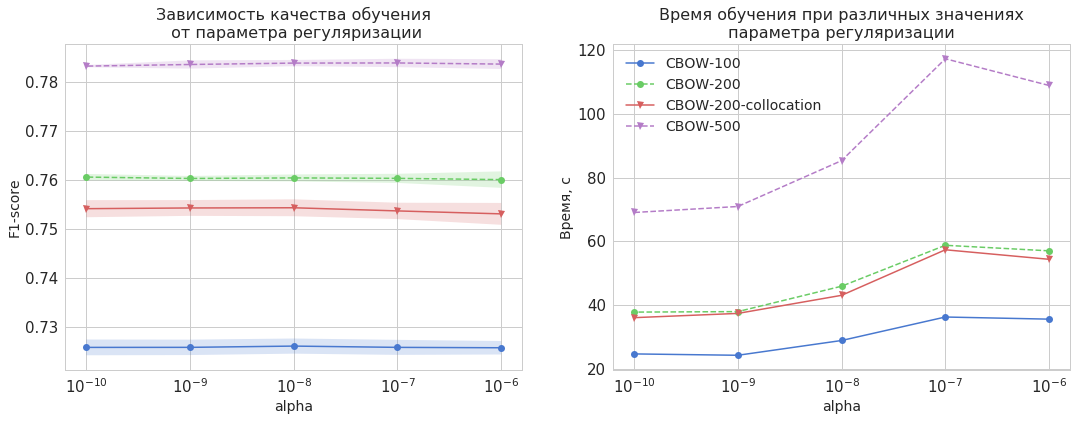

In [9]:
grids = ['gs_sgd-logistic-average_w2v_cbow_100.pkl', \
         'gs_sgd-logistic-average_w2v_cbow_200.pkl', \
         'gs_sgd-logistic-average_w2v_cbow_200_trigram.pkl', \
         'gs_sgd-logistic-average_w2v_cbow_500.pkl']
labels = ['CBOW-100','CBOW-200','CBOW-200-collocation','CBOW-500']

plot_cv(grids, labels, marks)

### Машина опорных векторов

In [15]:
names = ['average_w2v_cbow_100.bin.pkl', 'average_w2v_sg_100.bin.pkl',
         'average_w2v_cbow_200.bin.pkl', 'average_w2v_sg_200.bin.pkl',
         'average_w2v_cbow_200_trigram.bin.pkl', 'average_w2v_sg_200_trigram.bin.pkl',
         'average_w2v_cbow_500.bin.pkl', 'average_w2v_sg_500.bin.pkl']

In [16]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge', random_state=0, average=True, n_iter=100)

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-hinge-' + name[:-8], k=3, verbose=1, n_jobs=1, normalizing=False)
    print('\n')

average_w2v_cbow_100.bin.pkl
Number of features: 100
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.7min finished


Best parameters: {'alpha': 1e-08}
Training best model on full train data...
CPU times: user 3min 58s, sys: 32 ms, total: 3min 58s
Wall time: 34.5 s
Train score: 0.733 +/- 0.000
CV score: 0.726 +/- 0.002
Test score: 0.733

CPU times: user 46min 31s, sys: 804 ms, total: 46min 32s
Wall time: 6min 54s


average_w2v_sg_100.bin.pkl
Number of features: 100
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.7min finished


Best parameters: {'alpha': 1e-09}
Training best model on full train data...
CPU times: user 4min 2s, sys: 16 ms, total: 4min 2s
Wall time: 34.8 s
Train score: 0.764 +/- 0.000
CV score: 0.758 +/- 0.001
Test score: 0.764

CPU times: user 46min 15s, sys: 832 ms, total: 46min 16s
Wall time: 6min 50s


average_w2v_cbow_200.bin.pkl
Number of features: 200
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.9min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 6min 22s, sys: 12 ms, total: 6min 22s
Wall time: 55.4 s
Train score: 0.775 +/- 0.001
CV score: 0.761 +/- 0.001
Test score: 0.767

CPU times: user 1h 13min 11s, sys: 1.16 s, total: 1h 13min 12s
Wall time: 10min 43s


average_w2v_sg_200.bin.pkl
Number of features: 200
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.1min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 6min 26s, sys: 20 ms, total: 6min 26s
Wall time: 56 s
Train score: 0.793 +/- 0.001
CV score: 0.782 +/- 0.002
Test score: 0.788

CPU times: user 1h 14min 55s, sys: 1.15 s, total: 1h 14min 57s
Wall time: 10min 58s


average_w2v_cbow_200_trigram.bin.pkl
Number of features: 200
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.1min finished


Best parameters: {'alpha': 1e-08}
Training best model on full train data...
CPU times: user 6min 16s, sys: 268 ms, total: 6min 17s
Wall time: 54.6 s
Train score: 0.767 +/- 0.000
CV score: 0.754 +/- 0.002
Test score: 0.762

CPU times: user 1h 14min 18s, sys: 1.37 s, total: 1h 14min 19s
Wall time: 10min 58s


average_w2v_sg_200_trigram.bin.pkl
Number of features: 200
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.9min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 6min 23s, sys: 28 ms, total: 6min 23s
Wall time: 55.5 s
Train score: 0.790 +/- 0.001
CV score: 0.780 +/- 0.001
Test score: 0.790

CPU times: user 1h 13min 28s, sys: 1.25 s, total: 1h 13min 30s
Wall time: 10min 47s


average_w2v_cbow_500.bin.pkl
Number of features: 500
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 17.2min finished


Best parameters: {'alpha': 1e-06}
Training best model on full train data...
CPU times: user 12min 45s, sys: 16 ms, total: 12min 45s
Wall time: 1min 50s
Train score: 0.809 +/- 0.000
CV score: 0.784 +/- 0.001
Test score: 0.793

CPU times: user 2h 23min 52s, sys: 3.27 s, total: 2h 23min 56s
Wall time: 20min 54s


average_w2v_sg_500.bin.pkl
Number of features: 500
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 17.7min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 12min 21s, sys: 40 ms, total: 12min 21s
Wall time: 1min 46s
Train score: 0.824 +/- 0.001
CV score: 0.800 +/- 0.001
Test score: 0.807

CPU times: user 2h 26min 3s, sys: 3.39 s, total: 2h 26min 7s
Wall time: 21min 17s




**Результаты кросс-валидации**

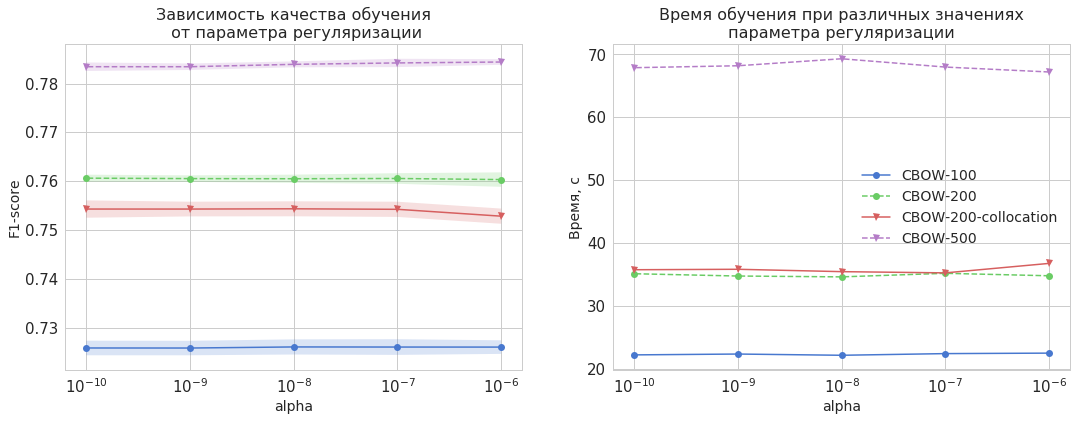

In [96]:
grids = ['gs_sgd-hinge-average_w2v_cbow_100.pkl', \
         'gs_sgd-hinge-average_w2v_cbow_200.pkl', \
         'gs_sgd-hinge-average_w2v_cbow_200_trigram.pkl', \
         'gs_sgd-hinge-average_w2v_cbow_500.pkl']
labels = ['CBOW-100','CBOW-200','CBOW-200-collocation','CBOW-500']

plot_cv(grids, labels, marks)

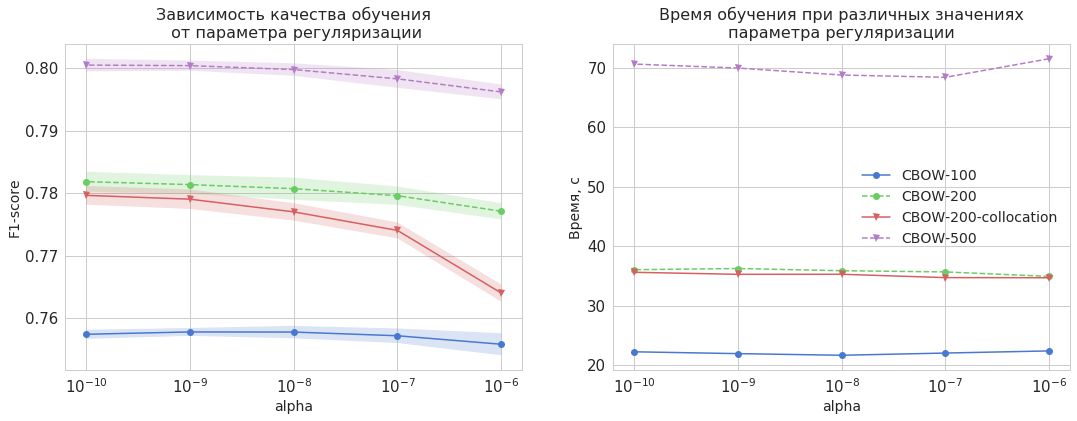

In [97]:
grids = ['gs_sgd-hinge-average_w2v_sg_100.pkl', \
         'gs_sgd-hinge-average_w2v_sg_200.pkl', \
         'gs_sgd-hinge-average_w2v_sg_200_trigram.pkl', \
         'gs_sgd-hinge-average_w2v_sg_500.pkl']
labels = ['CBOW-100','CBOW-200','CBOW-200-collocation','CBOW-500']

plot_cv(grids, labels, marks)

### Extra Trees / Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [ ]:
names = ['average_w2v_cbow_500.bin.pkl', 'average_w2v_sg_500.bin.pkl']

clf = RandomForestClassifier(n_jobs=8, class_weight='balanced', warm_start=True)
parameters = {'n_estimators': [400]}

print('Random Forest')
for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-forest-' + name[:-8], k=3, verbose=1, n_jobs=1)
    print('\n')

clf = ExtraTreesClassifier(n_jobs=8, class_weight='balanced', warm_start=True)
print('Extra Trees')
for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-extra-' + name[:-8], k=3, verbose=1, n_jobs=1)
    print('\n')

Random Forest
average_w2v_cbow_500.bin.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 29.1min finished


Best parameters: {'n_estimators': 500}
Training best model on full train data...
CPU times: user 776 ms, sys: 0 ns, total: 776 ms
Wall time: 997 ms
Train score: 1.000 +/- 0.000
CV score: 0.720 +/- 0.001
Test score: 0.739

CPU times: user 2h 57min 18s, sys: 39 s, total: 2h 57min 57s
Wall time: 47min 14s


average_w2v_sg_500.bin.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 41.0min finished


### Конкатенация признаков

In [18]:
models = ['average_w2v_cbow_500.bin.pkl', 'average_w2v_sg_500.bin.pkl']

X_cbow = np.nan_to_num(load_data(path_to_data + models[0]))
X_sg = np.nan_to_num(load_data(path_to_data + models[1]))
X_concat = np.hstack((X_cbow, X_sg))

In [19]:
loss = ['log', 'hinge']
parameters = {'alpha': [10**-i for i in range(3,11)]}

for L in loss:
    clf = SGDClassifier(n_jobs=8, class_weight='balanced', loss=L, random_state=0, average=True, n_iter=100)
    print("Функция потерь: %s" % L)
    %time modeling(clf, parameters, X_concat, y, 'gs_sgd-' + L + '-average_concat', k=3, verbose=1, n_jobs=1, normalizing=True)
    print('\n')

Функция потерь: log
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 82.7min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 34min 23s, sys: 160 ms, total: 34min 23s
Wall time: 5min 4s
Train score: 0.824 +/- 0.000
CV score: 0.790 +/- 0.000
Test score: 0.802

CPU times: user 10h 50min 10s, sys: 8.95 s, total: 10h 50min 19s
Wall time: 1h 33min 4s


Функция потерь: hinge
Train size: 114170
Test size: 48930
Searching best parameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 51.1min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 22min 51s, sys: 108 ms, total: 22min 52s
Wall time: 3min 36s
Train score: 0.824 +/- 0.000
CV score: 0.790 +/- 0.000
Test score: 0.802

CPU times: user 6h 36min 58s, sys: 8.18 s, total: 6h 37min 6s
Wall time: 58min 7s




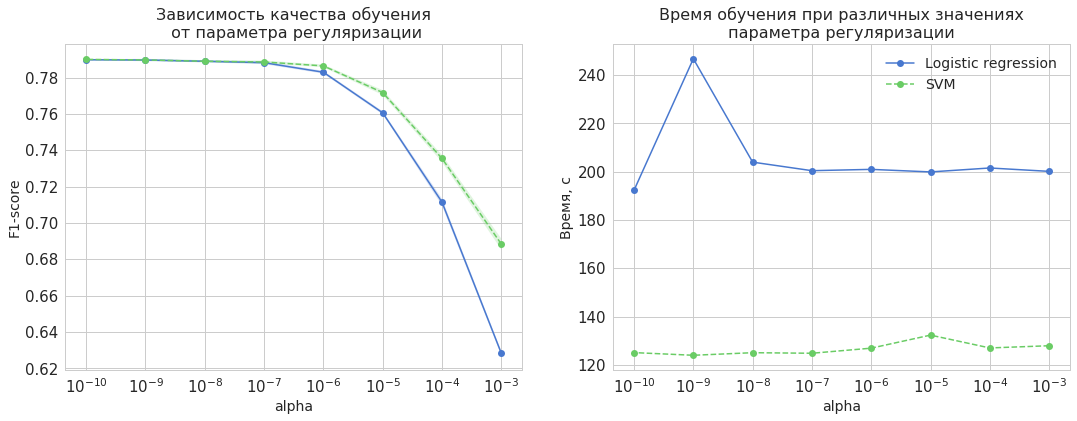

In [10]:
grids = ['gs_sgd-log-average_concat.pkl', \
         'gs_sgd-hinge-average_concat.pkl']
labels = ['Logistic regression','SVM']

plot_cv(grids, labels, marks[:2])

**Сцепление матриц признаков не дало улучшения!**

## Взвешенный средний вектор
### TF-IDF

In [23]:
names = ['average-tfidf_cbow_500.bin.pkl',
         'average-tfidf_sg_500.bin.pkl']

In [24]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-8], k=3, verbose=1, n_jobs=1)
    print('\n')

average-tfidf_cbow_500.bin.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 32.6min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 50s, sys: 156 ms, total: 18min 50s
Wall time: 2min 42s
Train score: 0.749 +/- 0.000
CV score: 0.717 +/- 0.000
Test score: 0.727

CPU times: user 4h 24min 49s, sys: 5.29 s, total: 4h 24min 54s
Wall time: 38min 1s


average-tfidf_sg_500.bin.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 33.2min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 44s, sys: 484 ms, total: 18min 45s
Wall time: 2min 43s
Train score: 0.761 +/- 0.000
CV score: 0.731 +/- 0.000
Test score: 0.740

CPU times: user 4h 28min 12s, sys: 5.77 s, total: 4h 28min 17s
Wall time: 38min 42s




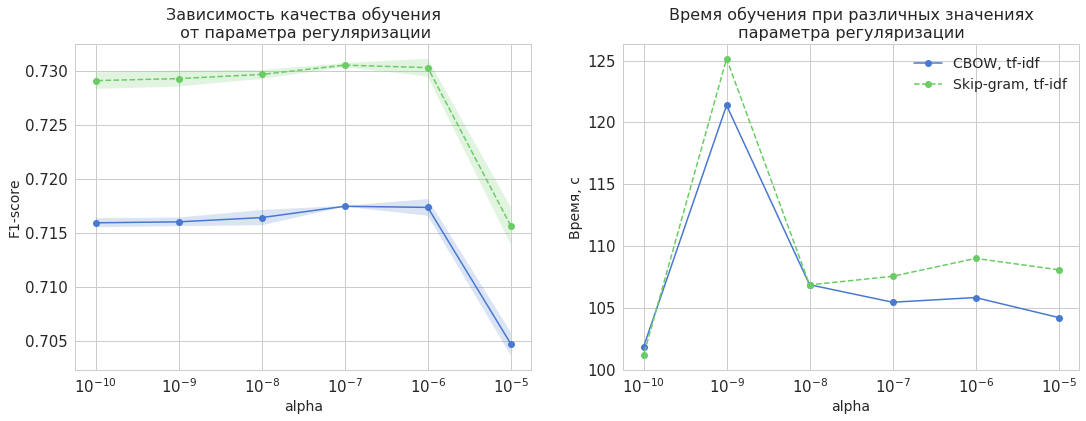

In [14]:
grids = ['gs_sgd-logistic-average-tfidf_cbow_500.pkl', \
         'gs_sgd-logistic-average-tfidf_sg_500.pkl']
labels = ['CBOW, tf-idf','Skip-gram, tf-idf']

plot_cv(grids, labels, marks[:2])

### IDF
[Описание]

In [16]:
names = ['average-idf_w2v_cbow_500.pkl',
         'average-idf_w2v_sg_500.pkl']

In [17]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-4], k=3, verbose=1, n_jobs=1)
    print('\n')

average-idf_w2v_cbow_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 32.8min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 30s, sys: 364 ms, total: 18min 30s
Wall time: 2min 41s
Train score: 0.815 +/- 0.000
CV score: 0.789 +/- 0.001
Test score: 0.795

CPU times: user 4h 24min 39s, sys: 5.4 s, total: 4h 24min 45s
Wall time: 38min 8s


average-idf_w2v_sg_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 33.1min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 16min 34s, sys: 156 ms, total: 16min 34s
Wall time: 2min 34s
Train score: 0.826 +/- 0.001
CV score: 0.804 +/- 0.002
Test score: 0.811

CPU times: user 4h 19min 16s, sys: 7.04 s, total: 4h 19min 23s
Wall time: 38min 27s




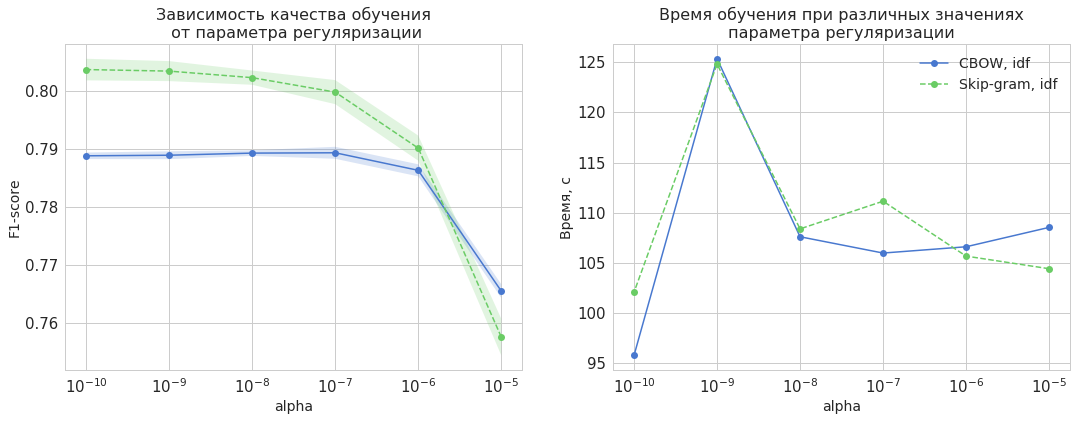

In [13]:
grids = ['gs_sgd-logistic-average-idf_w2v_cbow_500.pkl', \
         'gs_sgd-logistic-average-idf_w2v_sg_500.pkl']
labels = ['CBOW, idf','Skip-gram, idf']

plot_cv(grids, labels, marks[:2])

## Постпроцессинг
По материалам [статьи](https://arxiv.org/abs/1702.01417)  
Декомпозиция матрицы осуществляется методом [RandomizedPCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [33]:
from sklearn.decomposition import RandomizedPCA

### Подход А. Корректировка векторов документов

In [43]:
def postprocessing(X, threshold, pc=True):
    '''
    Description
    '''
    mu = np.mean(X, axis=0)
    V_adj = X - mu
    if not pc:
        return V_adj
    #
    # PCA decomposition
    pca = RandomizedPCA(n_components=threshold)
    pca.fit(X)
    U = pca.components_
    X_t = X.transpose()
    #
    # Matrix approximation
    X_appr = np.dot(np.dot(U, X_t).transpose(), U)
    #
    # Adjusted vectors
    V_post = V_adj - X_appr
    return V_post

#### Выбор числа главных компонет

In [26]:
pca = RandomizedPCA(n_components=20)
matrices = [X_cbow, X_sg, X_concat]
sigma_ratio = []

for matrix in matrices:
    pca.fit(matrix)
    sigma_ratio.append(pca.explained_variance_ratio_)

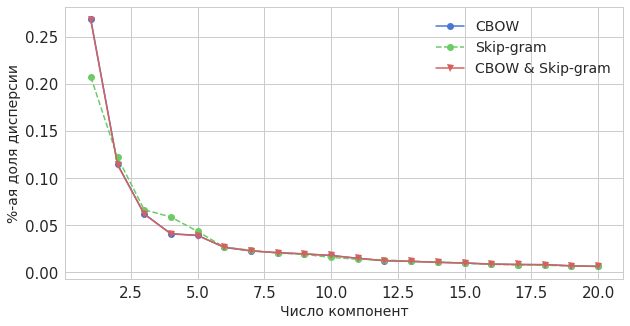

In [31]:
plt.figure(figsize=(10,5))
marks = ['o-','o--','v-']
labels = ['CBOW', 'Skip-gram', 'CBOW & Skip-gram']
    
for i, sigma in enumerate(sigma_ratio):
    plt.plot(range(1,21), sigma, marks[i], label=labels[i])
    plt.xlabel('Число компонент', fontsize=14)
    plt.ylabel('Доля объясненной дисперсии', fontsize=14)
    plt.legend(fontsize=14)
plt.show()

**Обучения моделей**

Будем отнимать последовательно 1, 2 и три главные компоненты

In [18]:
model = 'average_w2v_sg_500.bin.pkl'
X = np.nan_to_num(load_data(path_to_data + model))

clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(6,11)]}

In [22]:
for threshold in range(1,4):
    print('PC count: %d' % threshold)
    X_adj = postprocessing(X, threshold)
    %time modeling(clf, parameters, X_adj, y, 'gs_sgd-logistic-post-' + str(threshold) + model[:-8],\
                   k=3, verbose=1, n_jobs=1, normalizing=True)
    print('\n')

PC count: 1
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 28.6min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 26s, sys: 52 ms, total: 18min 26s
Wall time: 2min 53s
Train score: 0.827 +/- 0.001
CV score: 0.801 +/- 0.001
Test score: 0.807

CPU times: user 3h 40min 27s, sys: 2.54 s, total: 3h 40min 29s
Wall time: 34min 31s


PC count: 2
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 29.3min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 42s, sys: 84 ms, total: 18min 42s
Wall time: 2min 56s
Train score: 0.824 +/- 0.001
CV score: 0.799 +/- 0.001
Test score: 0.805

CPU times: user 3h 44min 11s, sys: 2.47 s, total: 3h 44min 14s
Wall time: 35min 18s


PC count: 3
Searching best parameters...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 29.4min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 18min 25s, sys: 68 ms, total: 18min 25s
Wall time: 2min 54s
Train score: 0.816 +/- 0.001
CV score: 0.794 +/- 0.001
Test score: 0.800

CPU times: user 3h 44min 41s, sys: 2.4 s, total: 3h 44min 44s
Wall time: 35min 18s




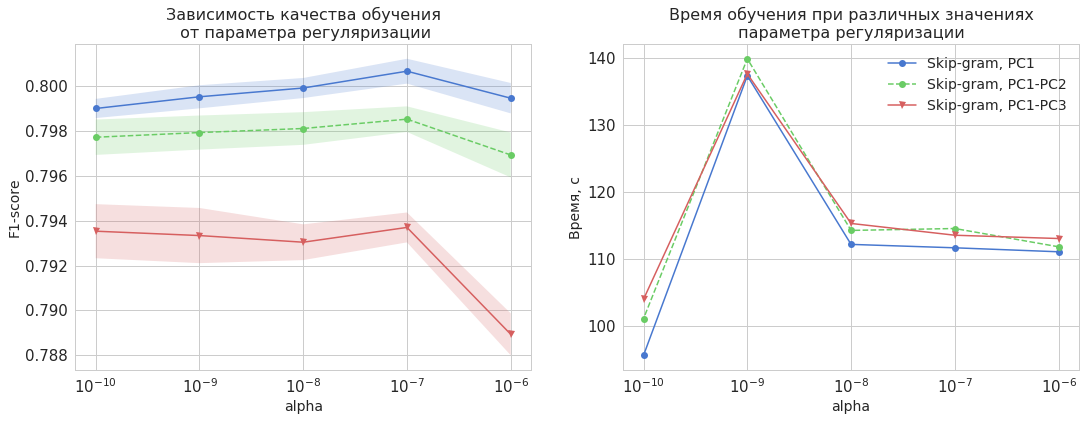

In [16]:
grids = ['gs_sgd-logistic-post-1average_w2v_sg_500.pkl', \
         'gs_sgd-logistic-post-2average_w2v_sg_500.pkl',
         'gs_sgd-logistic-post-3average_w2v_sg_500.pkl']
labels = ['Skip-gram, PC1','Skip-gram, PC1-PC2','Skip-gram, PC1-PC3']

plot_cv(grids, labels, marks[:3])

### Подход Б. Корректировка векторов слов
[Комментарий]
#### Главные компоненты

In [40]:
model_cbow = word2vec.KeyedVectors.load_word2vec_format(path_to_data + 'w2v_cbow_500.bin', binary=True)
model_sg = word2vec.KeyedVectors.load_word2vec_format(path_to_data + 'w2v_sg_500.bin', binary=True)

In [41]:
X_cbow = model_cbow.syn0
X_sg = model_sg.syn0

pca = RandomizedPCA(n_components=20)
matrices = [X_cbow, X_sg]
sigma_ratio = []

for matrix in matrices:
    pca.fit(matrix)
    sigma_ratio.append(pca.explained_variance_ratio_)

/home/kulesh271828/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


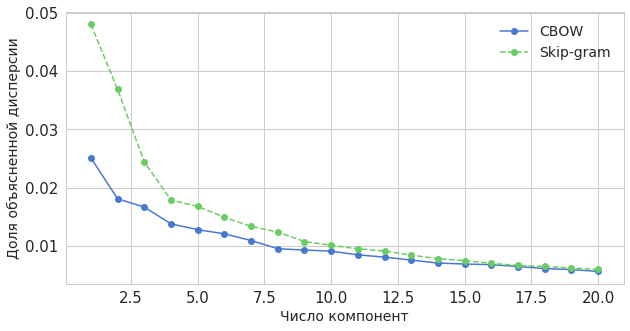

In [42]:
plt.figure(figsize=(10,5))
marks = ['o-','o--','v-']
labels = ['CBOW', 'Skip-gram']
    
for i, sigma in enumerate(sigma_ratio):
    plt.plot(range(1,21), sigma, marks[i], label=labels[i])
    plt.xlabel('Число компонент', fontsize=14)
    plt.ylabel('Доля объясненной дисперсии', fontsize=14)
    plt.legend(fontsize=14)
plt.show()

In [83]:
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [62]:
X_adj_cbow = postprocessing(X_cbow, 5, pc=True)
X_adj_sg = postprocessing(X_sg, 5, pc=True)

cbow_vocab = dict(zip(model_cbow.vocab.keys(), X_adj_cbow))
sg_vocab = dict(zip(model_sg.vocab.keys(), X_adj_sg))

In [70]:
path_to_w2v = '/home/kulesh271828/arxiv/models/word2vec/'
file = '~/corpora_lem.csv'

arxiv_id = pd.read_csv('~/corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


In [79]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

class LazyCorpora:
    def __init__(self, file, n):
        self.file = file
        self.n = n
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0]
            condition = len(content.split()) < 15000
            if condition:
                doc = content.split()
                doc = [token for token in doc if token[0] in alphabet]
                yield doc

corpora = LazyCorpora(file, n_corpora)

In [76]:
def get_idf(table, word, n_corpora):
    df_word = table[word]
    return np.log(n_corpora / df_word)

def docVector(words, model, voc, n_features, doc_num, idf=False, idf_table=None):
    
    vector = np.zeros((n_features,), dtype='float32')
    nwords = 0.
    weigth = 1
    
    for word in words:
        if word in voc and word not in stop: 
            nwords = nwords + 1.
            try: 
                if idf:
                    weigth = get_idf(idf_table, word, n_corpora)
                vector = np.add(vector, weigth * np.array(model[word]))
            except KeyError:
                continue
    vector = np.divide(vector, nwords)
    return vector


def docsTransformation(documents, model, voc, n_corpora, n_features, tfidf=False, tf_table=None, idf=False):
    counter = 0
    featureMatrix = np.zeros((n_corpora, n_features), dtype='float32')
    
    print("Making matrix of documents representation...")
    for doc in documents:
        if idf or tfidf:
            idf_table = Counter(doc)
        featureMatrix[counter] = docVector(doc, model, voc, n_features, counter, idf, idf_table)
        counter = counter + 1
        if counter%20000 == 0:
            print(counter)
    return featureMatrix

### Постпроцессинг с idf-взвешиванием

In [84]:
names = ['w2v_cbow_500.bin','w2v_sg_500.bin']
vocs = [cbow_vocab, sg_vocab]
n_features = 500
n_corpora = 163100

for name, voc in zip(names, vocs):
    model = word2vec.KeyedVectors.load_word2vec_format(path_to_data + name, binary=True)
    %time X = docsTransformation(corpora, model, voc, n_corpora, n_features, idf=True)
    pickling_data(path_to_data + 'average-idf_post-B_' + name[:-4], X)
    print('\n')

Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 46min 35s, sys: 5.03 s, total: 46min 40s
Wall time: 48min 23s


Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 42min 51s, sys: 4.59 s, total: 42min 56s
Wall time: 43min 53s




In [88]:
names = ['average-idf_post-B_w2v_cbow_500.pkl', 'average-idf_post-B_w2v_sg_500.pkl']

clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='hinge', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-hinge-' + name[:-4], k=3, verbose=1, n_jobs=1)
    print('\n')

average-idf_post-B_w2v_cbow_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 21.6min finished


Best parameters: {'alpha': 1e-07}
Training best model on full train data...
CPU times: user 11min 22s, sys: 148 ms, total: 11min 22s
Wall time: 1min 43s
Train score: 0.816 +/- 0.000
CV score: 0.789 +/- 0.001
Test score: 0.797

CPU times: user 2h 37min 38s, sys: 6.46 s, total: 2h 37min 45s
Wall time: 25min 13s


average-idf_post-B_w2v_sg_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.8min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 11min 27s, sys: 148 ms, total: 11min 27s
Wall time: 1min 47s
Train score: 0.827 +/- 0.001
CV score: 0.804 +/- 0.002
Test score: 0.812

CPU times: user 2h 37min 49s, sys: 5.19 s, total: 2h 37min 54s
Wall time: 24min 25s




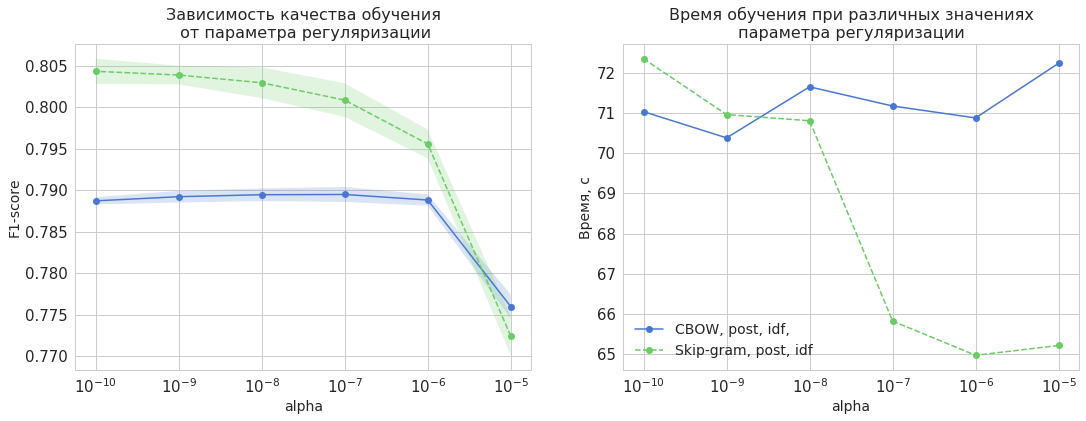

In [17]:
grids = ['gs_sgd-hinge-average-idf_post-B_w2v_cbow_500.pkl', \
         'gs_sgd-hinge-average-idf_post-B_w2v_sg_500.pkl']
labels = ['CBOW, post, idf, ','Skip-gram, post, idf']

plot_cv(grids, labels, marks[:2])

In [89]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_data + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-4], k=3, verbose=1, n_jobs=1)
    print('\n')

average-idf_post-B_w2v_cbow_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 52.1min finished


Best parameters: {'alpha': 1e-08}
Training best model on full train data...
CPU times: user 19min 7s, sys: 396 ms, total: 19min 7s
Wall time: 4min 35s
Train score: 0.818 +/- 0.000
CV score: 0.790 +/- 0.001
Test score: 0.796

CPU times: user 4h 36min 39s, sys: 7.88 s, total: 4h 36min 47s
Wall time: 1h 1min 20s


average-idf_post-B_w2v_sg_500.pkl
Number of features: 500
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 59.0min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 17min 28s, sys: 268 ms, total: 17min 29s
Wall time: 4min 28s
Train score: 0.827 +/- 0.001
CV score: 0.804 +/- 0.002
Test score: 0.812

CPU times: user 4h 31min 36s, sys: 8.17 s, total: 4h 31min 45s
Wall time: 1h 7min 57s




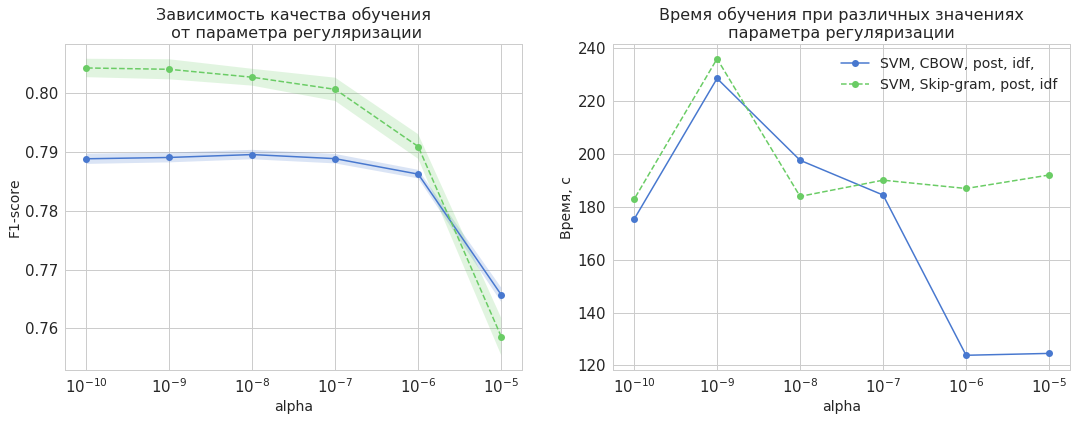

In [18]:
grids = ['gs_sgd-logistic-average-idf_post-B_w2v_cbow_500.pkl', \
         'gs_sgd-logistic-average-idf_post-B_w2v_sg_500.pkl']
labels = ['SVM, CBOW, post, idf, ','SVM, Skip-gram, post, idf']

plot_cv(grids, labels, marks[:2])

# FastText
A [Python interface](https://pypi.python.org/pypi/fasttext) for Facebook fastText library

In [26]:
path_to_ft = '/home/kulesh271828/arxiv/models/fasttext/'

In [27]:
[file for file in os.listdir(path_to_ft) if 'bin' in file]

['ft_cbow_300.model.bin',
 'ft_cbow_100.model.bin',
 'ft_sg_300.model.bin',
 'ft_sg_100.model.bin']

In [27]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

class LazyCorpora:
    def __init__(self, file, n):
        self.file = file
        self.n = n
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0]
            condition = len(content.split()) < 15000
            if condition:
                doc = content.split()
                doc = [token for token in doc if token[0] in alphabet]
                yield ' '.join(doc) 

In [36]:
file =  '~/corpora_lem.csv'
n = 164197
texts = LazyCorpora(file, n)

for text in texts:
    t = text
    print(t[:1000])
    break

the goal of this paper be to construct invariant dynamical object for not necessarily invertible smooth self map of compact manifold we prove result that take advantage of difference in rat of expansion in the term of sheaf cohomological long exact sequence to create unique lift of finite dimensional invariant subspace of one term of the sequence to invariant subspace of the precede term this allow to take invariant cohomological class and under the right circumstance construct unique current of give type include unique measure of give type that represent those class and be invariant under pullback dynamically interest self map may have plethora of invariant measure so the uniquess of the construct current be important it mean that if local growth be not too big compare to the growth rate of the cohomological class then the expand cohomological class give sufficient march order of any other such invariant current of the same type say from some local dynamical subsystem because we use s

### Вектор документа из модели
[Комментарий]

In [44]:
def ft_docsTransformation(texts, model, n_corpora=163100):
    counter = 0
    n_features = model.dim
    featureMatrix = np.zeros((n_corpora, n_features), dtype='float32')
    
    print("Making matrix of documents representation...")
    for text in texts:
        featureMatrix[counter] = np.array(model[text])
        counter = counter + 1
        if counter%20000 == 0:
            print(counter)
    return featureMatrix

In [53]:
#names = ['ft_doc-ft_sg_100.model.pkl', 'ft_doc-ft_cbow_100.model.pkl',
#        'ft_doc-ft_sg_300.model.pkl', 'ft_doc-ft_cbow_300.model.pkl']
    
names = ['ft_doc-ft_sg_300.model.pkl', 'ft_doc-ft_cbow_300.model.pkl']    

In [54]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_ft + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-10], k=3, verbose=1, n_jobs=1)
    print('\n')

ft_doc-ft_sg_300.model.pkl
Number of features: 300
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 22.4min finished


Best parameters: {'alpha': 1e-10}
Training best model on full train data...
CPU times: user 12min 34s, sys: 56 ms, total: 12min 34s
Wall time: 1min 49s
Train score: 0.796 +/- 0.001
CV score: 0.781 +/- 0.001
Test score: 0.787

CPU times: user 2h 59min 22s, sys: 3.41 s, total: 2h 59min 25s
Wall time: 26min 6s


ft_doc-ft_cbow_300.model.pkl
Number of features: 300
Searching best parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 22.5min finished


Best parameters: {'alpha': 1e-09}
Training best model on full train data...
CPU times: user 15min 17s, sys: 152 ms, total: 15min 17s
Wall time: 2min 10s
Train score: 0.804 +/- 0.000
CV score: 0.787 +/- 0.001
Test score: 0.793

CPU times: user 3h 5min 42s, sys: 3.4 s, total: 3h 5min 46s
Wall time: 26min 47s




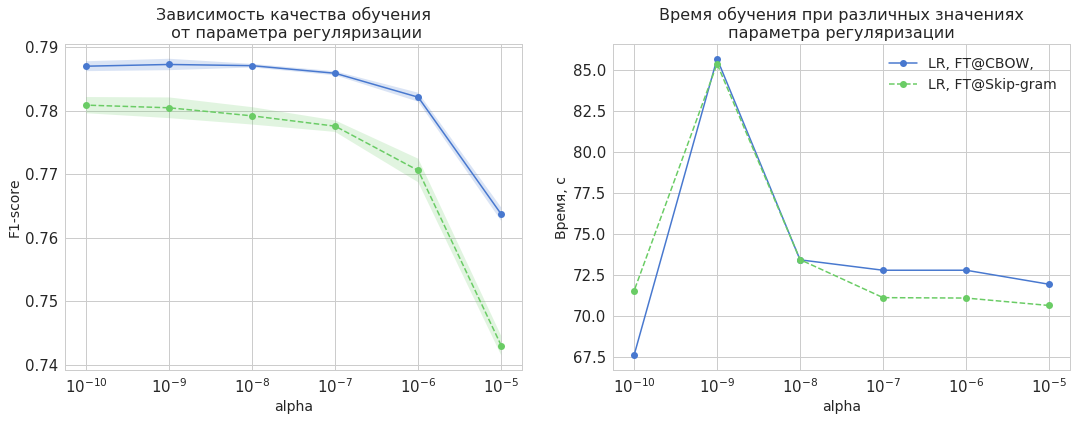

In [20]:
grids = ['gs_sgd-logistic-ft_doc-ft_cbow_300.pkl', \
         'gs_sgd-logistic-ft_doc-ft_sg_300.pkl']
labels = ['LR, FT@CBOW, ','LR, FT@Skip-gram']

plot_cv(grids, labels, marks[:2])

### Взвешенный средний вектор (IDF)

In [29]:
clf = SGDClassifier(n_jobs=8, warm_start=True, class_weight='balanced', loss='log', random_state=0, average=True, n_iter=100)
parameters = {'alpha': [10**-i for i in range(5,11)]}

In [ ]:
names = ['average_ft-idf_ft_cbow_300.model.pkl', 'average_ft-idf_ft_sg_300.model.pkl']

for name in names:
    print(name)
    X = np.nan_to_num(load_data(path_to_ft + name))
    print("Number of features: %d" % X.shape[1])
    %time modeling(clf, parameters, X, y, 'gs_sgd-logistic-' + name[:-10], k=3, verbose=1, n_jobs=1)
    print('\n')

>average_ft-idf_ft_cbow_300  
**Best parameters**: {'alpha': 1e-07}  
**CPU times**: user 13min 17s, sys: 228 ms, total: 13min 17s  
**Wall time**: 3min 42s  
**Train score**: 0.809 +/- 0.001  
**CV score**: 0.795 +/- 0.002  
**Test score**: 0.801  

>average_ft-idf_ft_sg_300  
**Best parameters**: {'alpha': 1e-10}  
**CPU times**: user 12min 49s, sys: 164 ms, total: 12min 49s  
**Wall time**: 3min 14s  
**Train score**: 0.822 +/- 0.001  
**CV score**: 0.807 +/- 0.001  
**Test score**: 0.813   

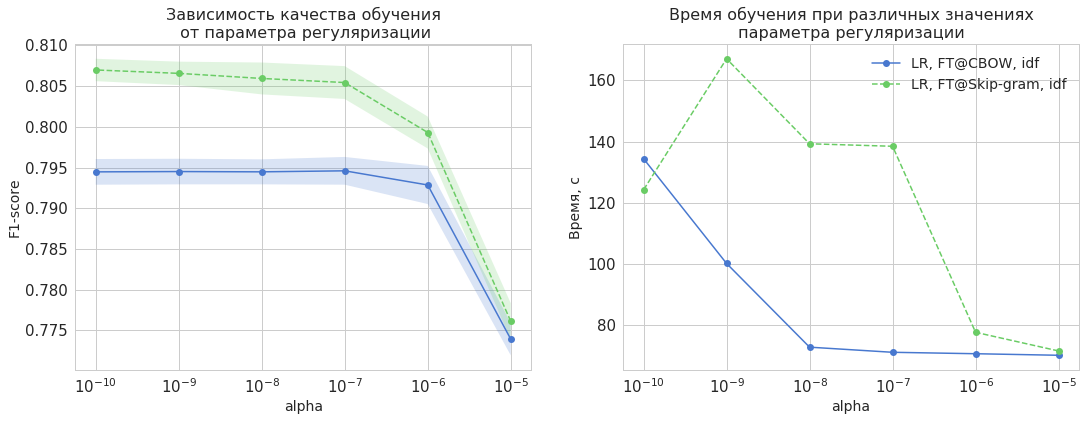

In [21]:
grids = ['gs_sgd-logistic-average_ft-idf_ft_cbow_300.pkl',
         'gs_sgd-logistic-average_ft-idf_ft_sg_300.pkl']
labels = ['LR, FT@CBOW, idf','LR, FT@Skip-gram, idf']

plot_cv(grids, labels, marks[:2])

In [23]:
chunck = pd.read_csv('~/corpora_lem.csv', chunksize=10)

In [26]:
for c in chunck:
    ex = c
    break

In [28]:
ex.head()

,arxiv_id,title,primary_category,categories,text
0,0704.0069v1,Dynamical Objects for Cohomologically Expandin...,math.DS,['math.DS'],the goal of this paper be to construct invaria...
1,0704.0129v1,On the total disconnectedness of the quotient ...,math.DS,"['math.DS', 'math-ph', 'math.AP']",in this paper we show that the quotient aubry ...
2,0704.0390v3,"Dual billiards, Fagnano orbits and regular pol...",math.DS,['math.DS'],in this article we consider the dual version o...
3,0704.0698v1,Rigorous Results for the Periodic Oscillation ...,math.DS,"['math.DS', 'math-ph']",right to elizabeth this dissertation would not...
4,0704.1006v1,A Denjoy Theorem for commuting circle diffeomo...,math.DS,['math.DS'],diffeomorphisms with mix and diffeomorphisms w...
